In [0]:
#@title MnistLoader
from keras.datasets import mnist
def load_mnist():
    # the data, shuffled and split between train and test sets
    from keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))
    return (x_train, y_train), (x_test, y_test)

Using TensorFlow backend.


In [0]:
#@title ModifiedMnistLoader
from keras.datasets import mnist
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import random
def load_modified_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_trainModified=np.zeros((60000,28,28,3),dtype=int)
    for x in range(x_train.shape[0]):
      x_trainModified[x] = cv2.cvtColor(x_train[x],cv2.COLOR_GRAY2RGB)
    x_testModified=np.zeros((10000,28,28,3),dtype=int)
    for x in range(x_test.shape[0]):
      x_testModified[x] = cv2.cvtColor(x_test[x],cv2.COLOR_GRAY2RGB)

    !wget "https://images2.alphacoders.com/101/1011957.jpg"
    sourceImage = mpimg.imread('1011957.jpg')

    sourceWidth = sourceImage.shape[1]
    sourceHeight = sourceImage.shape[0]
    width = 28
    height = 28

    for x in range(60000):
     x1 = random.randint(0, sourceWidth-width-1)
     y1 = random.randint(0, sourceHeight-height-1)
     croppedImage= sourceImage[y1:y1+height,x1:x1+width,:]
     for row in range(x_trainModified[x].shape[0]):
        for pixel in range(x_trainModified[x].shape[1]):
         if all(i<140 for i in x_trainModified[x][row][pixel]):
           x_trainModified[x][row][pixel]=croppedImage[row][pixel]

    for x in range(10000):
      x1 = random.randint(0, sourceWidth-width-1)
      y1 = random.randint(0, sourceHeight-height-1)
      croppedImage= sourceImage[y1:y1+height,x1:x1+width,:]
      for row in range(x_testModified[x].shape[0]):
        for pixel in range(x_testModified[x].shape[1]):
          if all(i<140 for i in x_testModified[x][row][pixel]):
            x_testModified[x][row][pixel]=croppedImage[row][pixel]
    
    x_trainModified = x_trainModified.reshape(-1, 28, 28, 3).astype('float32') / 255.
    x_testModified = x_testModified.reshape(-1, 28, 28, 3).astype('float32') / 255.
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))
    return (x_trainModified, y_train), (x_testModified, y_test)
    

In [0]:
#@title Cifar10Loader

from keras.datasets import cifar10
def load_cifar10():
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  x_train = x_train.reshape(-1, 32, 32, 3).astype('float32') / 255.
  x_test = x_test.reshape(-1, 32, 32, 3).astype('float32') / 255.
  y_train = to_categorical(y_train.astype('float32'))
  y_test = to_categorical(y_test.astype('float32'))
  return (x_train, y_train), (x_test, y_test)


In [0]:
import numpy as np
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator

# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [0]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Flatten, Dense
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 1
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (32, 32, 3)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(10, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [0]:
from keras import callbacks
import tensorflow as tf
# DECREASE LEARNING RATE EACH EPOCH
annealer = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * (0.9 ** epoch))
# TRAIN NETWORKS
history = [0] * nets
epochs = 50

log = callbacks.CSVLogger('log.csv')
tb = callbacks.TensorBoard(log_dir='tensorboard-logs',
                               batch_size=64, histogram_freq=0)
checkpoint = callbacks.ModelCheckpoint('weights-{epoch:02d}.h5', monitor='val_loss',
                                           save_best_only=True, save_weights_only=True, verbose=1)


for j in range(nets):
    (X_train2, Y_train2), (X_val2,Y_val2) = load_cifar10()
    history[j] = model[j].fit_generator(datagen.flow(X_train2,Y_train2, batch_size=64),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
        validation_data = (X_val2,Y_val2),verbose=0,
        callbacks=[log, tb, checkpoint,lr_decay])
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))


Epoch 00001: val_loss improved from inf to 1.13166, saving model to weights-01.h5

Epoch 00002: val_loss improved from 1.13166 to 0.78353, saving model to weights-02.h5

Epoch 00003: val_loss improved from 0.78353 to 0.75991, saving model to weights-03.h5

Epoch 00004: val_loss improved from 0.75991 to 0.66892, saving model to weights-04.h5

Epoch 00005: val_loss improved from 0.66892 to 0.62933, saving model to weights-05.h5

Epoch 00006: val_loss did not improve from 0.62933

Epoch 00007: val_loss improved from 0.62933 to 0.62189, saving model to weights-07.h5

Epoch 00008: val_loss improved from 0.62189 to 0.61137, saving model to weights-08.h5

Epoch 00009: val_loss did not improve from 0.61137

Epoch 00010: val_loss improved from 0.61137 to 0.57506, saving model to weights-10.h5

Epoch 00011: val_loss did not improve from 0.57506

Epoch 00012: val_loss improved from 0.57506 to 0.55618, saving model to weights-12.h5

Epoch 00013: val_loss improved from 0.55618 to 0.53466, saving m

In [0]:
for j in range(nets):
  print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

AttributeError: ignored

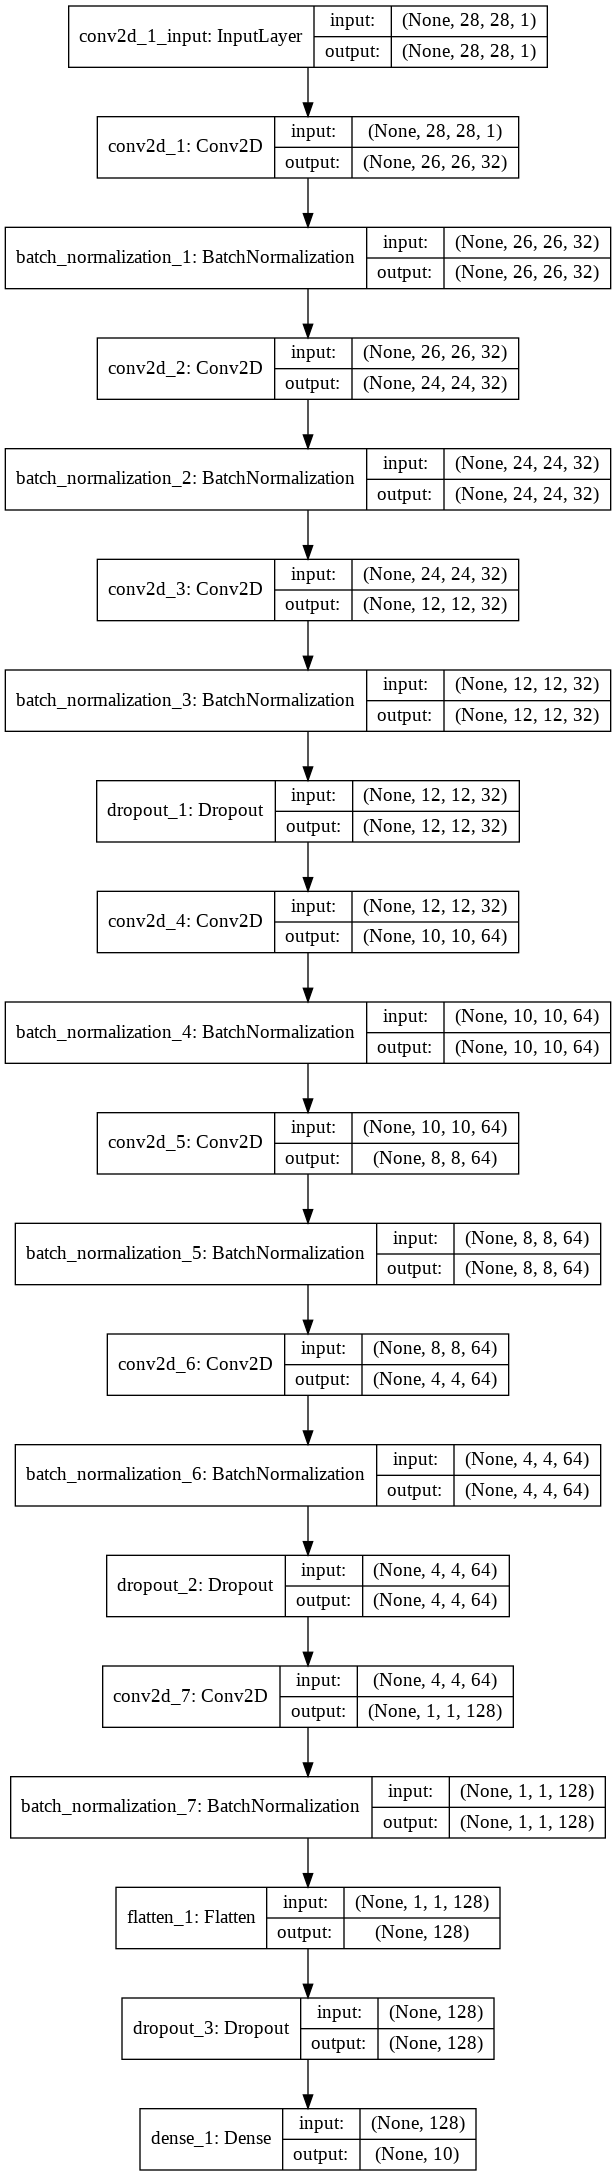

In [0]:
from keras.utils import plot_model
plot_model(model[0], to_file='model.png',show_shapes=True)

In [0]:
y_pred = model[0].predict(X_val2, batch_size=100)
print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(Y_val2, 1))/Y_val2.shape[0])

Test acc: 0.9968


In [0]:
model[0].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)       